In [41]:
# Librerias necesarias
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras import optimizers

from skimage import exposure
from PIL import Image
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt


In [2]:

# Define las rutas a las carpetas
base_dir = 'Photos'
categorias = ['benigno', 'maligno']

datos = []
etiquetas = []
desviacion_estandar_antes = []
desviacion_estandar_despues = []

In [3]:

# Carga las imágenes y sus etiquetas
for categoria in categorias:
    categoria_path = os.path.join(base_dir, categoria)
    for imagen_nombre in os.listdir(categoria_path):
        imagen_path = os.path.join(categoria_path, imagen_nombre)
        imagen = Image.open(imagen_path)
        
        # Calcular desviación estándar antes del preprocesamiento
        imagen_array = np.array(imagen)
        desviacion_estandar_antes.append(np.std(imagen_array))
        
        datos.append(imagen)
        etiquetas.append(categorias.index(categoria))  # Asigna 0 para 'No tiene' y 1 para 'Tiene'
        
       

In [4]:
# Convertir a arrays de NumPy para facilitar su manejo
desviacion_estandar_antes = np.array(desviacion_estandar_antes)

# Imprimir resultados
print("Desviación estándar antes del preprocesamiento:", desviacion_estandar_antes.mean())


Desviación estándar antes del preprocesamiento: 52.67622109559935


In [5]:
datos_procesados1 =[]
for image in datos:
    imagen_array = np.array(image)
     # Aplicar CLAHE
    imagen_clahe = exposure.equalize_adapthist(imagen_array)
    datos_procesados1.append(imagen_clahe)


In [6]:
def grafica_comparacion(titulo1,titulo2,datos,datos_procesados,cantidad):
    for i in range(cantidad):
        # Aplicar CLAHE
        imagen_array = np.array(datos[i])
        imagen_clahe = np.array(datos_procesados[i])

        fig = plt.figure(figsize = (10,6)) 
        fig.add_subplot(121)
        plt.title(titulo1)
        plt.imshow(imagen_array, cmap='gray')
        
        fig.add_subplot(122)
        plt.title(titulo2)
        plt.imshow(imagen_clahe, cmap='gray')
        plt.show()



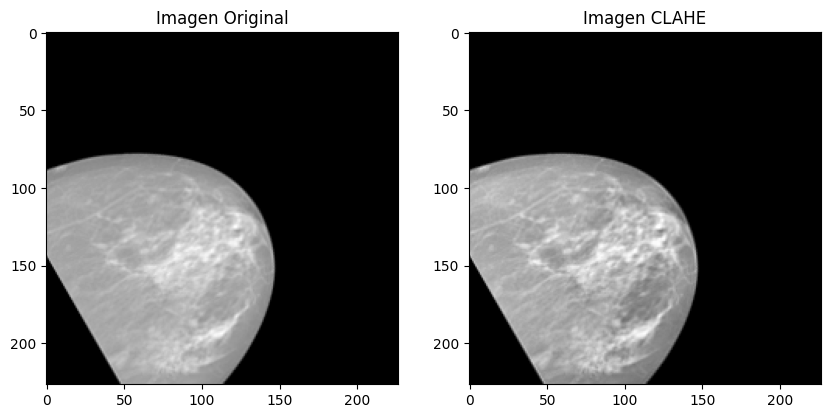

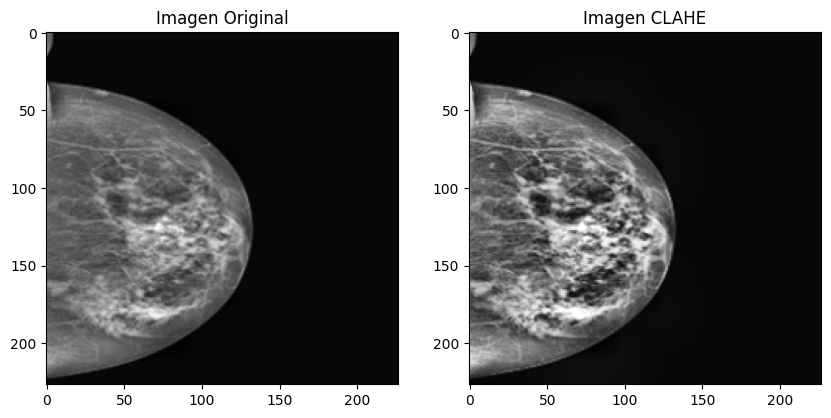

In [7]:
#GRAFICA 1

grafica_comparacion("Imagen Original","Imagen CLAHE",datos,datos_procesados1,2)

In [ ]:
datos_procesados2=[]
for image in datos_procesados1:
    # Aplicar reducción de ruido gaussiano con OpenCV
    imagen_gaussiana = cv2.GaussianBlur(np.array(image), (5, 5), 0)
    datos_procesados2.append(imagen_gaussiana)

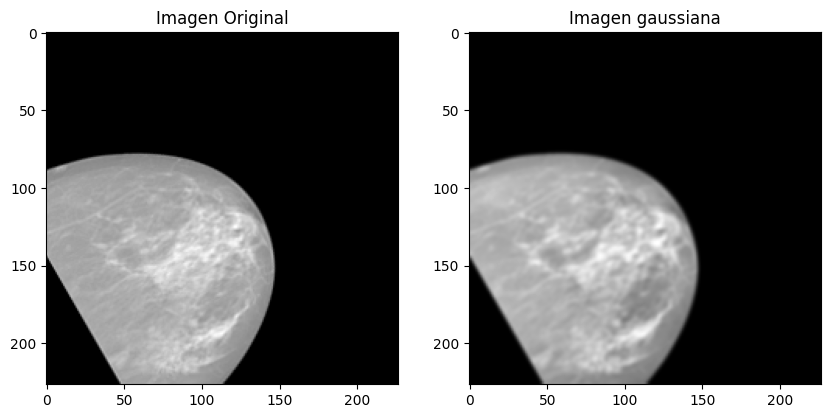

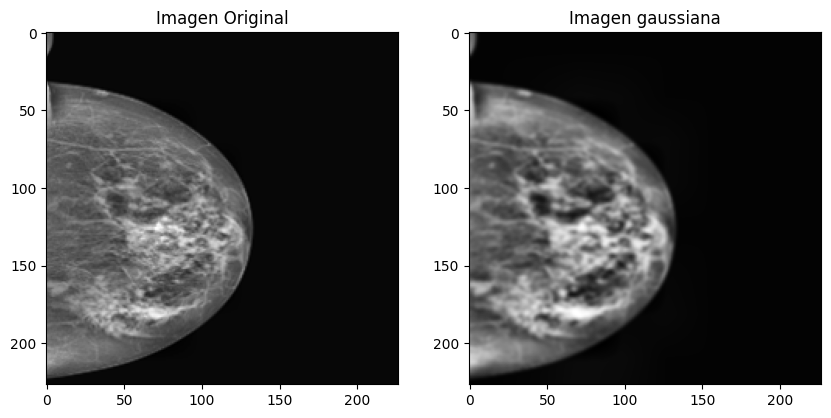

In [10]:
#GRAFICA 
grafica_comparacion("Imagen Original","Imagen gaussiana",datos,datos_procesados2,2)

Dado la comparación de las imágenes con filtro gaussiano y las originales del dataset, se decide no aplicar este filtro ya que el suavisado produce que las imágenes de vean borrosas, a diferencias de lo hecho con CLAHE que aumente el contraste de la imagen

In [8]:
datos_procesados3=[]
for image in datos_procesados1:

    # Aplicar Unsharp Masking (USM) con SciPy
    blurred = ndimage.gaussian_filter(image, 1)
    imagen_usm = image + 0.5 * (image - blurred)
    datos_procesados3.append(imagen_usm)
    

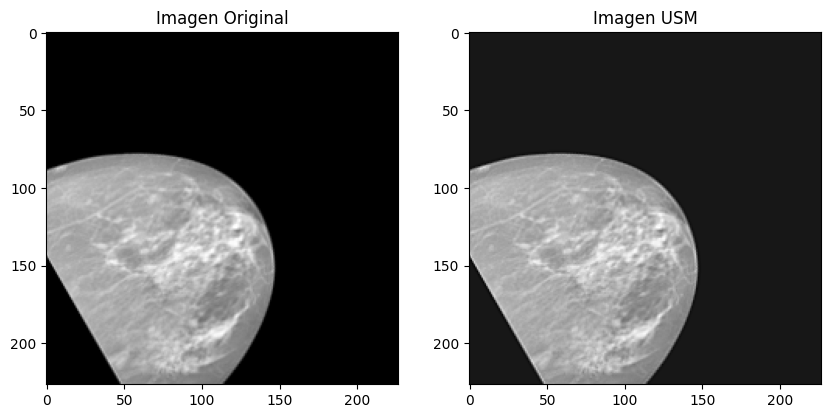

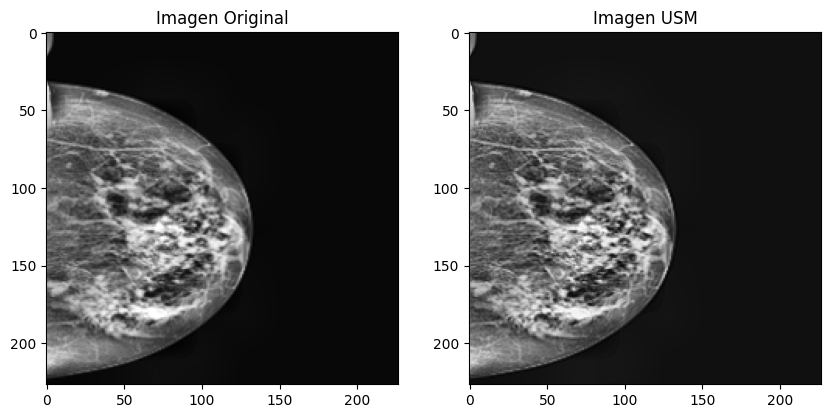

In [9]:
#GRAFICA 3
grafica_comparacion("Imagen Original","Imagen USM",datos_procesados1,datos_procesados3,2)

In [11]:

# Iterar sobre cada imagen en el arreglo
for i in range(len(datos_procesados3)):
    # Convertir la imagen de escala de grises a un objeto Image
    image_gray = Image.fromarray(datos_procesados3[i])

    # Verificar si la imagen ya tiene tres canales
    if image_gray.mode != 'RGB':
        # Convertir la imagen a RGB
        image_rgb = image_gray.convert("RGB")
    else:
        # Si ya tiene tres canales, mantenerla igual
        image_rgb = image_gray
    
    # Guardar la imagen de tres canales de nuevo en el arreglo
    datos_procesados3[i] = np.array(image_rgb)


In [16]:

datos_finales=[]
print(type(datos_procesados3[0]))
    

<class 'numpy.ndarray'>


In [12]:
# Calcular desviación estándar después del preprocesamiento
desviacion_estandar_despues=[]
for image in datos_procesados3:
    desviacion_estandar_despues.append(np.std(image))


In [13]:
desviacion_estandar_despues = np.array(desviacion_estandar_despues)
print("Desviación estándar después del preprocesamiento:", desviacion_estandar_despues.mean())

Desviación estándar después del preprocesamiento: 0.04666267025947632


In [15]:
datos.clear()
datos_procesados1.clear()
#datos_procesados3.clear()


In [18]:
etiquetas=np.array(etiquetas)
datos_procesados3 = np.array(datos_procesados3)

# Dividir los datos en entrenamiento (70%) y datos restantes (30%)
X_train, X_remaining, y_train, y_remaining = train_test_split(datos_procesados3, etiquetas, test_size=0.3, random_state=42)

# Dividir los datos restantes en validación (50%) y prueba (50%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)


In [19]:
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (17203, 227, 227, 3)
Forma de X_val: (3686, 227, 227, 3)
Forma de X_test: (3687, 227, 227, 3)
Forma de y_train: (17203,)
Forma de y_val: (3686,)
Forma de y_test: (3687,)


In [ ]:
#EN ESTE CASO NO SE USA ESTO PORQUE LAS IMAGENES SON RGB 
#PARA PODER ENTRENAR LA VGG16
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_val = np.expand_dims(X_val,axis=-1)


# Verifica las nuevas formas
print(f"Nueva forma de datos de entrenamiento: {X_train.shape}")
print(f"Nueva forma de datos de prueba: {X_test.shape}")
print(f"Nueva forma de datos de validacion: {X_test.shape}")

In [20]:


# Crea un generador de datos de imagen con aumento de datos para el entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Reescala las imágenes por el factor dado  
    shear_range=0.2,  # Cizallamiento
    horizontal_flip=True,
    zoom_range=0.2,  # Zoom
    fill_mode='nearest'  # Estrategia para rellenar los píxeles que pueden aparecer después de una transformación
)



# Para el conjunto de prueba solo se normalizan los datos
test_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

# Suponiendo que 'datos_entrenamiento' y 'datos_prueba' están en la forma correcta (num_samples, height, width, channels)
# y que 'etiquetas_entrenamiento' y 'etiquetas_prueba' están codificadas adecuadamente
# (por ejemplo, one-hot encoding para clasificación multiclase)

# Crea un generador que suministrará los datos de entrenamiento al modelo durante el entrenamiento
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=32  # Tamaño del lote
)

# Crea un generador para los datos de prueba
test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size=32
)

val_generator = val_datagen.flow(
    X_val,
    y_val,
    batch_size=32
)
                                                


In [24]:
# checking GPU
if tf.test.gpu_device_name():
    print(f"GPU detected: {tf.test.gpu_device_name()}")
else:
    print("No GPU detected")

GPU detected: /device:GPU:0


In [31]:

# callback para detener el entrenamiento si se alcanza el accuracy deseado
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("Accuracy alcanzado")
      self.model.stop_training = True


In [32]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
]

In [33]:
stop = myCallback()


"\nmodel = Sequential()\n\n\nmodel.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l2', input_shape=(227, 227, 1)))\nmodel.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l2'))\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2'))\nmodel.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer='l2'))\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))\nmodel.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(BatchNormalization())\n\nmodel.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer='l2'))\nmodel.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer='l2'))\nmodel.add(MaxPooling2D((2, 2)))\nmodel.add(BatchNormalization())\n\nmodel.add(Flatten())\nmodel.add(Dense(512, activation='relu', kernel

In [39]:
# Cargar el modelo VGG16 pre-entrenado sin las capas densas
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(227, 227, 3))

# Congelar las capas convolucionales para evitar que se actualicen durante el entrenamiento
for layer in vgg_model.layers:
    layer.trainable = False

x=Flatten()(vgg_model.output)
prediction = Dense(1,activation='sigmoid')(x)

model = Model(inputs=vgg_model.input,outputs=prediction)

# Resumen del modelo
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [40]:
adam = optimizers.Adam()
model.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [43]:
checkpoint = ModelCheckpoint(filepath='model_1',verbose=1,save_best_only=True)
callbacks=[stop,checkpoint]

In [44]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator,
                        epochs=20,
                        validation_data=val_generator,
                        verbose=1,
                        callbacks=callbacks)

Epoch 1/20
538/538 [==============================] - ETA: 0s - loss: 0.7175 - accuracy: 0.5240
Epoch 1: val_loss improved from inf to 0.70553, saving model to model_1


INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


538/538 [==============================] - 178s 328ms/step - loss: 0.7175 - accuracy: 0.5240 - val_loss: 0.7055 - val_accuracy: 0.4460
Epoch 2/20
538/538 [==============================] - ETA: 0s - loss: 0.7156 - accuracy: 0.5325
Epoch 2: val_loss did not improve from 0.70553
538/538 [==============================] - 187s 347ms/step - loss: 0.7156 - accuracy: 0.5325 - val_loss: 0.7488 - val_accuracy: 0.5540
Epoch 3/20
221/538 [===========>..................] - ETA: 1:56 - loss: 0.7153 - accuracy: 0.5236

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

In [1]:
"""
# Obtener clases y etiquetas
classes = {0: 'benigno', 1: 'maligno'}
labels = [classes[label] for label in y_test]

# un lote de imágenes de prueba
test_images = X_test
test_labels = y_test

# predicciones en el lote de prueba
predictions = model.predict(test_images)

num_images_to_show = min(len(test_labels), 15)

plt.figure(figsize=(15, 10))
for i in range(num_images_to_show):
    true_label = labels[i]
    predicted_label = classes[np.argmax(predictions[i])]

    plt.subplot(3, 5, i+1)
    plt.imshow(test_images[i])
    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()
"""


"\n# Obtener clases y etiquetas\nclasses = {0: 'benigno', 1: 'maligno'}\nlabels = [classes[label] for label in y_test]\n\n# un lote de imágenes de prueba\ntest_images = X_test\ntest_labels = y_test\n\n# predicciones en el lote de prueba\npredictions = model.predict(test_images)\n\nnum_images_to_show = min(len(test_labels), 15)\n\nplt.figure(figsize=(15, 10))\nfor i in range(num_images_to_show):\n    true_label = labels[i]\n    predicted_label = classes[np.argmax(predictions[i])]\n\n    plt.subplot(3, 5, i+1)\n    plt.imshow(test_images[i])\n    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')\n    plt.axis('off')\n\nplt.tight_layout()\nplt.show()\n"

"\n# Función para definir el modelo\ndef build_model(hp):\n\n    hp_activation = hp.Choice('activation', values=['relu'])\n    hp_layer_1 = hp.Int('conv1_filters', values=[32,64])\n    hp_layer_2 = hp.Int('conv2_filters', values=[64,128])\n    hp_layer_3 = hp.Int('conv3_filters', values=[128,256])\n    hp_layer_4 = hp.Int('conv4_filters', values=[256,512])\n    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])\n\n    model = Sequential()\n    model.add(Conv2D(filters=hp_layer_1, kernel_size=(3, 3), activation=hp_activation, input_shape=[150, 150, 3]))\n    model.add(Conv2D(filters=hp_layer_2, kernel_size=(3, 3), activation=hp_activation))\n    model.add(MaxPool2D(pool_size=(3, 3), padding='valid'))\n\n    model.add(Conv2D(filters=hp_layer_3, kernel_size=(3, 3), activation=hp_activation))\n    model.add(Conv2D(filters=hp_layer_4, kernel_size=(3, 3), activation=hp_activation))\n    model.add(MaxPool2D(pool_size=(2, 2)))\n\n    model.add(Flatten())\n    model.add(De

'# Realiza la búsqueda de hiperparámetros utilizando el generador\ntuner.search(train_image_generator, epochs=10, validation_data=val_image_generator)'